In [1]:
import os
import sys

import h5py 
import pandas as pd
import numpy as np
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

import time
import json
from joblib import Parallel, delayed

from scipy.ndimage.filters import gaussian_filter


In [2]:
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.color import rgb2gray

## t-SNE output to probability map

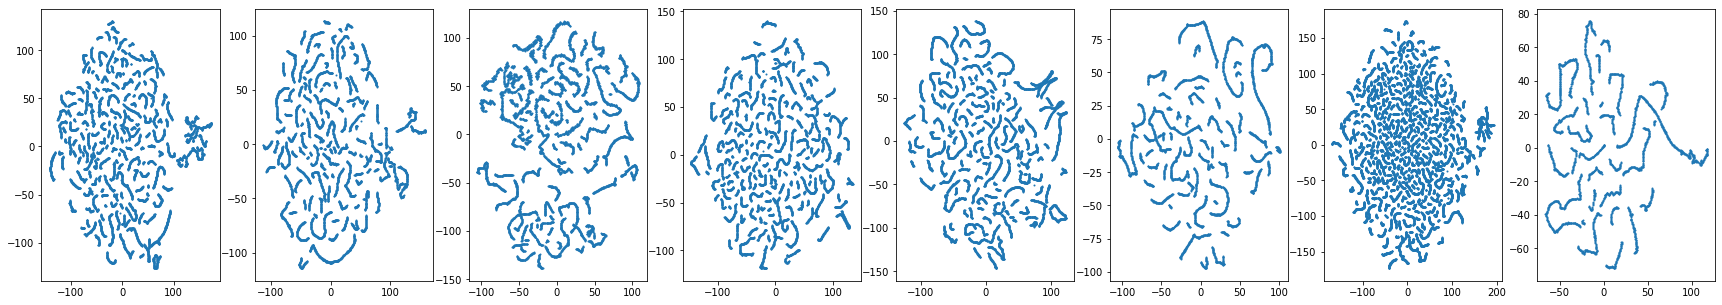

In [6]:
tsne_folder = '../Results/20201027-165720_tsne_694files_6feats/'

fig, axes = plt.subplots(1,8, figsize=(30,5))

for i in range(8):
    tsne_output = os.path.join(tsne_folder, f'tsne_out_array_path_exp{i}.npy')
    X_tsne = np.load(tsne_output)
    axes[i].scatter(X_tsne[:,0],X_tsne[:,1], s=1)

In [ ]:
## We use the mapping to the wavelet-datafolder to get the labels (experiments)
with open(os.path.join(tsne_folder, 'tsne_metadata.txt'), 'r') as outfile:
    tsne_settings = json.load(outfile)

wv_norm_array_path = tsne_settings['wv_norm_array_path']
wv_norm_array = np.load(wv_norm_array_path)

## To get the files/experiments to which each datapoint in tsne output belong to. 
y_ciona = wv_norm_array[:, -1]

In [ ]:
c_pal = sns.color_palette("tab20", 20)
ciona_colors = [c_pal[int(i)] for i in y_ciona]

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

axes[0].scatter(X_tsne[:,0],X_tsne[:,1], s=0.1)
axes[1].scatter(X_tsne[:,0],X_tsne[:,1], c=ciona_colors, s=0.1)

### t-SNE to 2D histogram 

#### Method 1

In [ ]:
def data_coord2view_coord(p, vlen, pmin, pmax):
    dp = pmax - pmin
    dv = (p - pmin) / dp * vlen
    return dv


def nearest_neighbours(xs, ys, reso, n_neighbours):
    im = np.zeros([reso, reso])
    extent = [np.min(xs), np.max(xs), np.min(ys), np.max(ys)]

    xv = data_coord2view_coord(xs, reso, extent[0], extent[1])
    yv = data_coord2view_coord(ys, reso, extent[2], extent[3])
    for x in range(reso):
        for y in range(reso):
            xp = (xv - x)
            yp = (yv - y)

            d = np.sqrt(xp**2 + yp**2)

            im[y][x] = 1 / np.sum(d[np.argpartition(d.ravel(), n_neighbours)[:n_neighbours]])

    return im, extent

In [ ]:
resolution = 250

fig, axes = plt.subplots(2, 2)

for ax, neighbours in zip(axes.flatten(), [0, 1, 100, 500]):
    if neighbours == 0:
        ax.plot(X_tsne[:,0],X_tsne[:,1], 'k.', markersize= 0.05)
        ax.set_aspect('equal')
        ax.set_title("Scatter Plot")
    else:
        im, extent = nearest_neighbours(X_tsne[:,0],X_tsne[:,1], resolution, neighbours)
        ax.imshow(im, origin='lower', extent=extent, cmap=cm.jet)
        ax.set_title("Smoothing over %d neighbours" % neighbours)
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])

#### Method 2

In [ ]:
def myplot(x, y, s, bins= 5000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent


In [ ]:
fig, axs = plt.subplots(1,1)

img, extent = myplot(X_tsne[:,0],X_tsne[:,1], 32)
axs.imshow(img, extent=extent, origin='lower', cmap=cm.jet)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))

sigmas = [0, 48, 32, 64]

for ax, s in zip(axs.flatten(), sigmas):
    if s == 0:
        ax.plot(X_tsne[:,0],X_tsne[:,1], 'b.', markersize= 1)
        ax.set_title("Scatter plot")
    else:
        img, extent = myplot(X_tsne[:,0],X_tsne[:,1], s)
        ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)

#### Method 3 

In [ ]:
def tsne_to_hist2D(x, y, bins= 5000):
    
    xmin = np.amin(x) - 50
    xmax = np.amax(x) + 50
    ymin = np.amin(y) - 50
    ymax = np.amax(y) + 50
   
        
    tsne_hist2D, xedges, yedges = np.histogram2d(x, y, bins=bins, range = [[xmin, xmax], [ymin, ymax]])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return tsne_hist2D, extent

def hist2D_to_probMap(tsne_hist2D, s):
    
    prob_heatmap = gaussian_filter(tsne_hist2D, sigma=s)
    return prob_heatmap.T

Let us study the effect of bin size here 

In [ ]:
test_nbins = [100, 300, 500, 1000, 5000]

In [ ]:
x = X_tsne[:,0]
y = X_tsne[:,1]

fig, axs = plt.subplots(1,len(test_nbins), figsize=(25,5))
plt.style.use("default")

for i_b, nbins in enumerate(test_nbins):
    hist_out = tsne_to_hist2D(x, y, bins= nbins)
    axs[i_b].imshow(hist_out[0].T, extent = hist_out[1], origin='lower')

### Histogram to probability map

In [ ]:
test_sigmas = [1.5, 16, 32, 64, 100]

In [ ]:
fig, axs = plt.subplots(1,len(test_sigmas), figsize=(20,5))
plt.style.use("default")
for i_s, s in enumerate(test_sigmas):
    tsne_prob_map = hist2D_to_probMap(hist_out[0], s)
    axs[i_s].imshow(tsne_prob_map, extent=hist_out[1], origin='lower', cmap=cm.jet)
    axs[i_s].set_title(f'Sigma = {s}')

### Effect of nbins and sigma 

In [ ]:
fig, axes = plt.subplots(len(test_nbins),len(test_sigmas), figsize=(25,25))
plt.style.use("default")


import itertools

axs = axes.flatten()
for i, params in enumerate(list(itertools.product(test_nbins, test_sigmas))):
    
    print(i, params[0], params[1])
    hist_out = tsne_to_hist2D(x, y, bins= params[0])
    tsne_prob_map = hist2D_to_probMap(hist_out[0], params[1])
    axs[i].imshow(tsne_prob_map, extent=hist_out[1], origin='lower', cmap=cm.jet)
    axs[i].set_title(f'Bins = {params[0]}, Sigma = {params[1]}')

In [ ]:
hist_out = tsne_to_hist2D(x, y, bins= 5000)
tsne_prob_map = hist2D_to_probMap(hist_out[0], 64)
plt.imshow(tsne_prob_map, extent=hist_out[1], origin='lower', cmap=cm.jet)
plt.title(f'Bins = {params[0]}, Sigma = {params[1]}')

## Watershed to identify regions in the map

### To binary

In [ ]:
plt.imshow(tsne_prob_map, extent=hist_out[1], origin='lower', cmap='gray')

In [ ]:
from skimage import restoration
from skimage import img_as_float

In [ ]:
im = tsne_prob_map
im_float = img_as_float(im)

In [ ]:
im_denoised = restoration.denoise_nl_means(im_float, h=0.05)

In [ ]:
plt.imshow(im_denoised, cmap='gray')
ax = plt.axis('off')

In [ ]:
from skimage.filters import sobel

elevation_map = sobel(im_denoised)
plt.imshow(elevation_map)

In [ ]:
from skimage import morphology

from skimage.filters import threshold_otsu


markers = np.zeros_like(im_denoised)
thresh = threshold_otsu(im_denoised) 
markers[im_denoised < thresh] = 1
markers[im_denoised < thresh] = 2
# markers[x.astype(np.int), y.astype(np.int)] = np.arange(len(x)) + 1

In [ ]:
markers = morphology.opening(markers, morphology.disk(30))

In [ ]:
markers.shape

In [ ]:
plt.imshow(markers)

### Watershed

In [ ]:

from scipy import ndimage
from skimage import morphology
# Black tophat transformation (see https://en.wikipedia.org/wiki/Top-hat_transform)
hat = ndimage.black_tophat(im_denoised, 7)
# Combine with denoised image
hat -= 0.3 * im_denoised
# Morphological dilation to try to remove some holes in hat image
hat = morphology.dilation(hat)
plt.imshow(hat, cmap='Spectral')

In [ ]:
labels_hat = morphology.watershed(hat, markers)
from skimage import color
color_labels = color.label2rgb(labels_hat, im_denoised)
plt.imshow(color_labels)

In [ ]:
# A different markers image: laplace filter
lap = ndimage.gaussian_laplace(im_denoised, sigma=0.7)
lap = restoration.denoise_nl_means(lap, h=0.002)

In [ ]:
plt.imshow(lap, cmap='Spectral'); plt.colorbar()

In [ ]:
labels_lap = morphology.watershed(lap, markers)
color_labels = color.label2rgb(labels_lap, im_denoised)
plt.imshow(color_labels)

#### Method 3

In [ ]:
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)

In [ ]:
distance.shape

In [ ]:
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image)

In [ ]:
local_maxi.shape

In [ ]:
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

print(markers.shape, labels.shape)

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

##  Watershed

In [ ]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage.filters import rank
from skimage.util import img_as_ubyte

In [ ]:
image = img_as_ubyte(tsne_prob_map)

In [ ]:
plt.hist(image)

In [ ]:
plt.imshow(image, extent=hist_out[1], origin='lower', cmap=plt.cm.gray)

In [ ]:
# image_eroded = morphology.erosion(image, disk(50))
# plt.imshow(image_eroded, extent=hist_out[1], origin='lower')

In [ ]:
plt.imshow(image, extent=hist_out[1], origin='lower')

In [ ]:
markers = rank.gradient(image, disk(5)) < 10
markers = ndi.label(markers)[0]

In [ ]:
# local gradient (disk(2) is used to keep edges thin)
gradient = rank.gradient(image, disk(2))

In [ ]:
plt.imshow(gradient, cmap= cm.nipy_spectral)
plt.title("Local Gradient")

In [ ]:
plt.imshow(markers, cmap=plt.cm.nipy_spectral)
plt.title("Markers")

In [ ]:
# process the watershed
labels = watershed(gradient, markers)

In [ ]:
plt.imshow(image, cmap=plt.cm.jet)
# plt.imshow(labels, cmap=plt.cm.jet, alpha=.5)
plt.title("Segmented")

## Watershed -4 

In [ ]:
image = img_as_ubyte(tsne_prob_map)

In [ ]:
markers = rank.gradient(image, disk(5)) == 1
markers = ndi.label(markers)[0]

In [ ]:
# local gradient (disk(2) is used to keep edges thin)
# gradient = rank.gradient(image, disk(2))

In [ ]:
ranks = rank.gradient(image, disk(2))

In [ ]:
np.unique(ranks)

In [ ]:
markers = rank.gradient(image, disk(100)) 

In [ ]:
np.unique(markers)

In [ ]:
np.sum(markers)

In [ ]:
plt.imshow(markers)

In [ ]:
result = watershed(tsne_prob_map,labels,watershed_line = True)

In [ ]:
plt.imshow(labels)